In [275]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import numpy as np

from random import sample
import seaborn as sns

from netgraph import Graph

In [4]:
# let's try to use this twitter dataset
# it's in data/congress-twitter
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10493874/

def load_congress_data_from_json(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    data = data[0]

    inList = data['inList']
    inWeight = data['inWeight']
    outList = data['outList']
    outWeight = data['outWeight']
    usernameList = data['usernameList']

    return inList, inWeight, outList, outWeight, usernameList

def create_congress_graph(inList, inWeight, outList, outWeight, usernameList):
    G = nx.DiGraph()
    for i, username in enumerate(usernameList):
        G.add_node(i, username=username)
    for i in range(len(inList)):
        for j, in_node in enumerate(inList[i]):
            G.add_edge(in_node, i, weight=inWeight[i][j])
        for j, out_node in enumerate(outList[i]):
            G.add_edge(i, out_node, weight=outWeight[i][j])
    return G

In [5]:
inList, inWeight, outList, outWeight, usernameList = load_congress_data_from_json('data/congress-twitter/congress_network_data.json')
G = create_congress_graph(inList, inWeight, outList, outWeight, usernameList)
print(G)

DiGraph with 475 nodes and 13289 edges


In [6]:
# sanity checks
print(G.number_of_nodes())
print(G.number_of_edges())

# from congress.edgelist,
# should be 0 4 {'weight': 0.002105263157894737}
# and 4 0 {'weight': 0.0036496350364963502}
print(G.nodes[0])
print(G.nodes[4])
print(G.get_edge_data(0, 4))
print(G.get_edge_data(4, 0))

475
13289
{'username': 'SenatorBaldwin'}
{'username': 'SenBlumenthal'}
{'weight': 0.002105263157894737}
{'weight': 0.0036496350364963502}


In [196]:
# try implementing model from the community detection paper
def community_detection(G, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    x0 = np.random.rand(n) # generate random opinions
    print('x0 =', x0) # in the future, let's use political party as initial opinion
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    print('Ni_0 =', Ni)

    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(x[Ni_confidence] - x[i])

        print('x =', x)
        print('computed new opinions')
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            print('x =', x)
            break
        # update rho 
        # rho *= rho
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    return communities_list

In [197]:
# try implementing model from the community detection paper
def community_detection_weighted(G, with_parties=False, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    x0 = np.random.rand(n) # generate random opinions
    print('x0 =', x0) # in the future, let's use political party as initial opinion
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix
    A_normaized = A / np.max(A)

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    print('Ni_0 =', Ni)

    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(A_normaized[i, Ni_confidence] * (x[Ni_confidence] - x[i]))

        print('x =', x)
        print('computed new opinions')
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            print('x =', x)
            break
        # update rho 
        # rho *= rho
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    return communities_list

In [167]:
ex_subgraph = subgraph

In [153]:
def to_hex_string(color):
    if color == 'blue':
        return '#2471a3'
    elif color == 'red':
        return '#cb4335'
colors = ['blue', 'red', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'red']
colors = [to_hex_string(color) for color in colors]
colors

['#2471a3',
 '#cb4335',
 '#cb4335',
 '#2471a3',
 '#cb4335',
 '#2471a3',
 '#cb4335',
 '#2471a3',
 '#2471a3',
 '#cb4335']

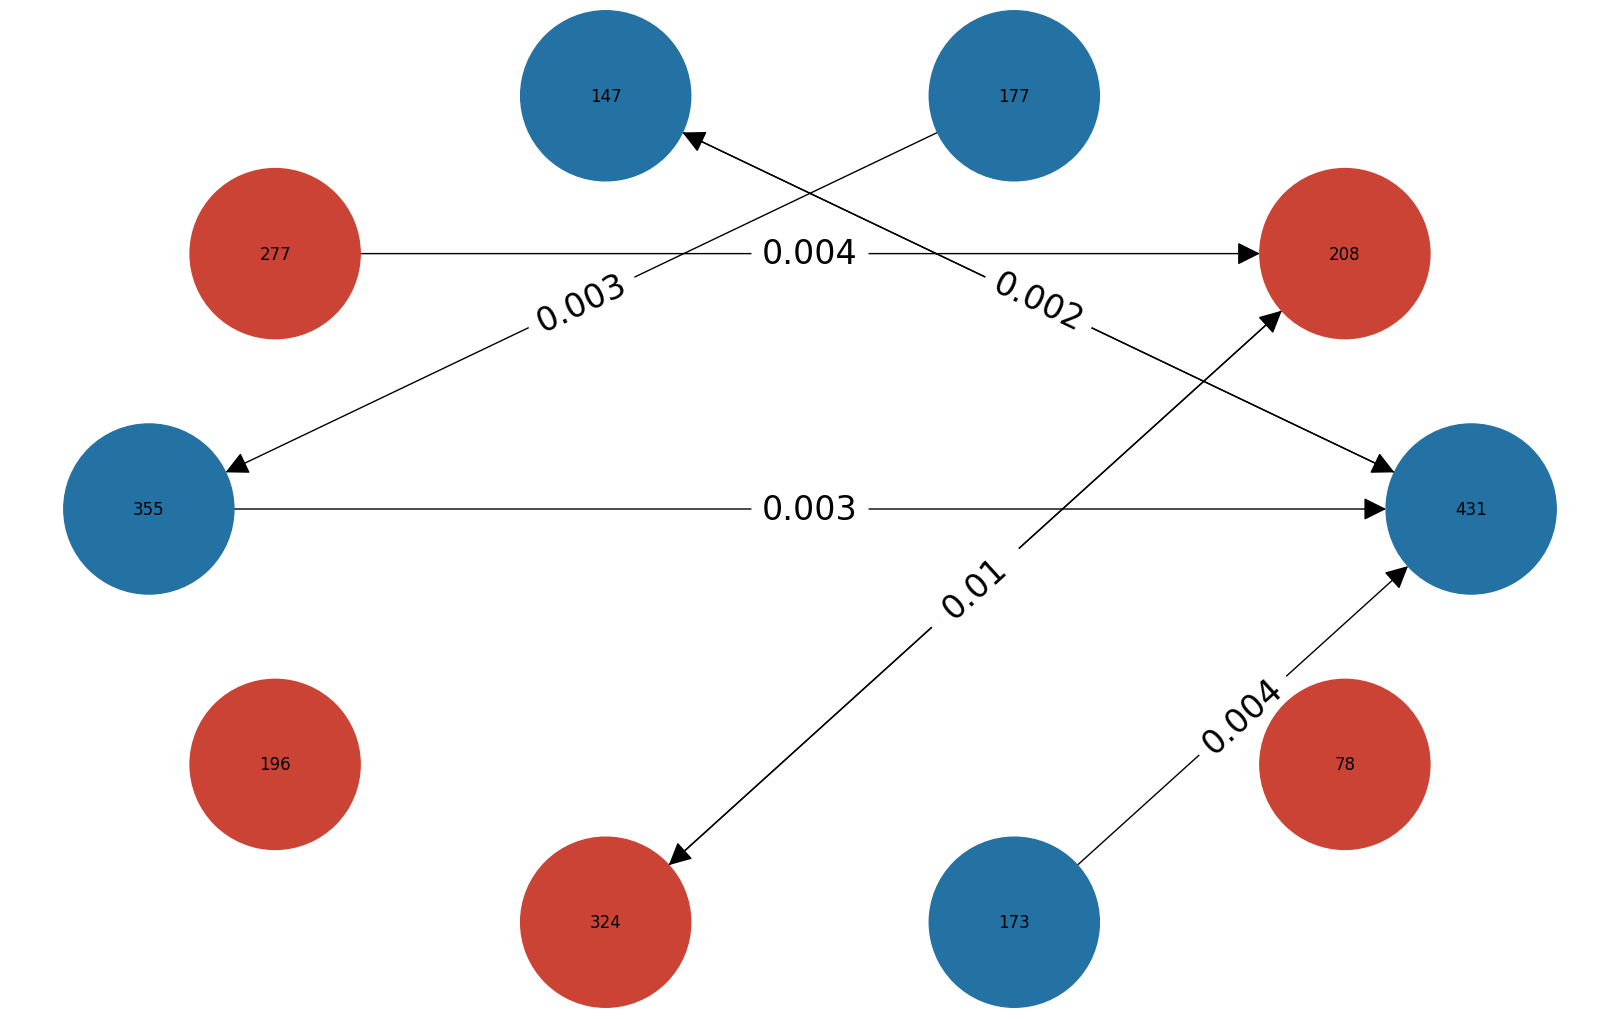

In [165]:
edge_weights = nx.get_edge_attributes(subgraph, 'weight')
rounded_edge_weights = {key: round(value, 3) for key, value in edge_weights.items()}
fig = plt.figure(figsize=(16, 10))
nx.draw_shell(subgraph, node_size=15000, arrowsize=35, node_color=colors, with_labels=True)
nx.draw_networkx_edge_labels(subgraph, pos=nx.shell_layout(subgraph), edge_labels=rounded_edge_weights, font_size=24)
plt.savefig('figs/ex.png')

In [241]:
usernameList
with open('data/parties.json', 'r') as file:
    data = json.load(file)
parties = [item['party'] for item in data]
encoded_parties = [1 if party == 'D' else -1 if party == 'R' else 0 for party in parties]
# sanity check
assert (len([i for i, party in enumerate(encoded_parties) if party == -1]) + len([i for i, party in enumerate(encoded_parties) if party == 1]) + len([i for i, party in enumerate(encoded_parties) if party == 0])) == len(encoded_parties)

def generate_initial_opinions_parties(p):
    x0 = []
    for i in range(len(p)):
        if p[i] == 1:
            x0.append(np.random.uniform(0, 1))
        elif p[i] == -1:
            x0.append(np.random.uniform(-1, 0))
        else:
            x0.append(np.random.uniform(-1, 1))
    return np.array(x0)

In [344]:
# try implementing model from the community detection paper
def community_detection_weighted(G, with_parties=False, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    if with_parties:
        x0 = generate_initial_opinions_parties(encoded_parties) # use party opinions
    else:
        x0 = np.random.rand(n) # generate random opinions
    # print('x0 =', x0)
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix
    A_normaized = A / np.max(A)

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    # print('starting iterations')
    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(A_normaized[i, Ni_confidence] * (x[Ni_confidence] - x[i]))
        # if t % 1000 == 0:
            # print('t =', t)
            # print('x =', x)
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            break
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    # print('communities_list =', communities_list)

    node_to_community = {}
    for i, community in enumerate(communities_list):
        for node in community:
            node_to_community[node] = i
    # print('node_communities =', node_to_community)
    return x, node_to_community

In [346]:
delta_grid = np.linspace(0.01, 0.5, 50)
results = []
for delta in delta_grid:
    xs, node_to_community = community_detection_weighted(G, with_parties=True, delta=delta)
    unique_communities = set(node_to_community.values())
    print('finished delta =', delta, 'with', len(unique_communities), 'unique communities')
    results.append(
        {
            'delta': delta,
            'xs': xs,
            'node_to_community': node_to_community
        }
    )

with open('results/delta_grid.json', 'w') as file:
    json.dump(results, file)

x0 = [ 0.43051579 -0.81268807  0.69686833 -0.59895582  0.53434339 -0.15356857
  0.90900451 -0.63056028 -0.96551126  0.2572633   0.85795416 -0.55520888
  0.86190901  0.8120288   0.23183117 -0.8547842   0.16656568 -0.80937567
  0.08604096 -0.78094778 -0.8758296  -0.44540189 -0.40081949 -0.14748101
  0.78635301  0.13868058 -0.52437932  0.72827268 -0.37983231  0.840524
 -0.09166487 -0.79194672 -0.57500244  0.23091298 -0.40994529  0.44633403
  0.07771384  0.44892592 -0.83599017 -0.10898255 -0.01103119 -0.8373969
  0.96488913  0.96412552 -0.88262652  0.84101451  0.00133339 -0.11923721
  0.14611506 -0.11172538  0.54433094 -0.91222413  0.04665238  0.94878818
  0.21772801  0.95101913 -0.3557715  -0.23271902  0.58790468  0.74358185
  0.3237294   0.41361581 -0.55557833  0.94461519 -0.52104568  0.83298009
 -0.91075538 -0.1517318   0.96618562 -0.70045578  0.74441627  0.70368054
 -0.1042958  -0.03986718  0.67316551  0.37164357  0.750896    0.27905533
 -0.48353487  0.97732878 -0.28657209 -0.50170092 

KeyboardInterrupt: 

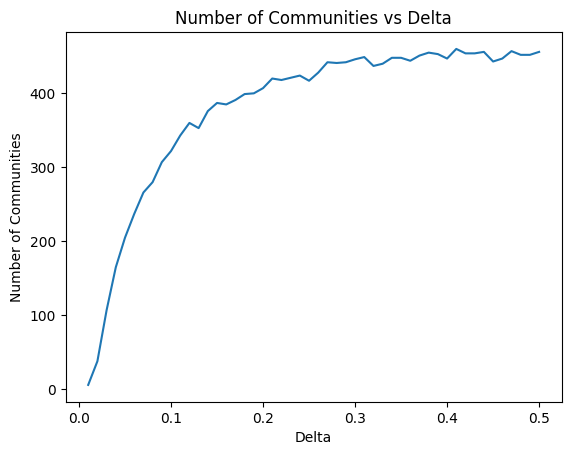

In [265]:
import matplotlib.pyplot as plt

num_opinions = [len(communities) for communities in communities_list]

plt.plot(delta_grid, num_opinions)
plt.xlabel('Delta')
plt.ylabel('Number of Communities')
plt.title('Number of Communities vs Delta')
plt.show()

In [342]:
def draw_community_graph(G, x, node_to_community):
    unique_communities = set(node_to_community.values())
    if len(unique_communities) <= 10:
      community_to_color = {
          0: 'tab:blue',
          1: 'tab:red',
          2: 'tab:green',
          3: 'tab:orange',
          4: 'tab:purple',
          5: 'tab:brown',
          6: 'tab:pink',
          7: 'tab:gray',
          8: 'tab:olive',
          9: 'tab:cyan'
      }
      node_color = {node: community_to_color[node_to_community[node]] for node in node_to_community.keys()}
    else:
      node_color = None

    Graph(G,
          node_color=node_color, node_edge_width=0, edge_alpha=0.1,
          node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
          edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
    )

    plt.show()

x0 = [0.57589688 0.15611356 0.6668768  0.42589239 0.50747472 0.70137398
 0.23684875 0.10299266 0.07884315 0.07438789 0.59754247 0.60128274
 0.22444611 0.35635252 0.09713634 0.47534566 0.07414103 0.4357091
 0.5086741  0.89626359 0.95547053 0.77248953 0.04670594 0.34280354
 0.69391211 0.71303621 0.83161704 0.08264143 0.32975871 0.88824242
 0.85074036 0.14915474 0.12032675 0.22873863]
starting iterations
converged at t = 784
x = [0.43713095 0.41015183 0.41015183 0.41015183 0.44144541 0.4414454
 0.4414454  0.41015183 0.37193814 0.3621786  0.44144541 0.43713095
 0.41015183 0.41015183 0.37193814 0.37193814 0.4414454  0.43713095
 0.37150152 0.43713095 0.37193814 0.43713095 0.37193814 0.37193814
 0.37194012 0.37193827 0.37225202 0.37194012 0.37193827 0.37225202
 0.37193814 0.37193827 0.37193814 0.37193814]
communities_list = [[8, 14, 15, 20, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33], [1, 2, 3, 7, 12, 13], [0, 11, 17, 19, 21], [4, 5, 6, 10, 16], [26, 29], [9], [18]]
node_communities = {8: 0, 14: 

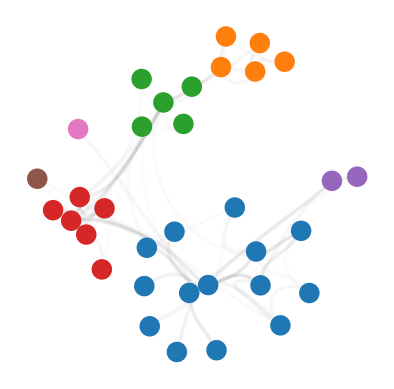

In [343]:
x, node_to_community = community_detection_weighted(nx.karate_club_graph(), with_parties=False, delta=0.3)
draw_community_graph(nx.karate_club_graph(), x, node_to_community)